In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import math

from collections import Counter
from imblearn.pipeline import make_pipeline as make_pipeline_imb # To do our transformation in a unique time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn import linear_model

from sklearn.metrics import precision_score,recall_score, f1_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score


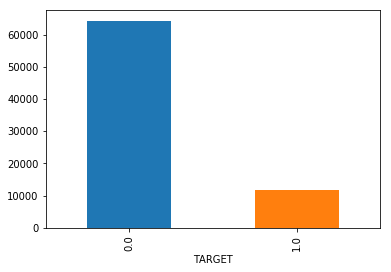

In [14]:
data = pd.read_csv('../1.data-preparation/new-data/data_Y1.csv')
data.loc[data['TARGET'] > 0, 'TARGET'] = 1
data.groupby(['TARGET']).size().plot.bar()

In [15]:
data.drop("MemberID", axis = 1, inplace = True)
data.drop("Year", axis = 1, inplace = True)

y = data['TARGET']
X = data.loc[:, data.columns != 'TARGET']

# from sklearn.preprocessing import MinMaxScaler, StandardScaler

# scaler = StandardScaler().fit(X)
# X = scaler.transform(X)

In [16]:
def eval(model, X_test, y_test):
    pred_y = model.predict(X_test) # your predicted y values
    # The root mean square logarithmic error
    pred_y = pred_y.round(0).astype(int)
    msle = np.mean( (np.log(pred_y + 1) - np.log(y_test + 1)) ** 2)
    rmsle = math.sqrt(msle)
    print ("RMSLE: %.4f" % rmsle)

def submit(model, name):
    data_submit = pd.read_csv('../1.data-preparation/new-data/data_Y2.csv')
    data_submit.drop("MemberID", axis = 1, inplace = True)
    data_submit.drop("Year", axis = 1, inplace = True)

    y_submit = data_submit['TARGET']
    X_submit = data_submit.loc[:, data_submit.columns != 'TARGET']
    X_submit = scaler.transform(X_submit)
    
    data = pd.read_csv('../1.data-preparation/new-data/data_Y2.csv')
    pred_y = model.predict(X_submit)
    
    submission = pd.DataFrame()
    submission['MemberID'] = data['MemberID']
    submission['DaysInHospital'] = pred_y
    
    print("Size: {}".format(submission.groupby('DaysInHospital').size()))
    
    submission.to_csv(name ,index=False)
    
def test(model):
    data_submit = pd.read_csv('../1.data-preparation/new-data/data_Y2.csv')
    data_submit.drop("MemberID", axis = 1, inplace = True)
    data_submit.drop("Year", axis = 1, inplace = True)

    y_submit = data_submit['TARGET']
    X_submit = data_submit.loc[:, data_submit.columns != 'TARGET']
#     X_submit = scaler.transform(X_submit)
    
    eval(model, X_submit, y_submit)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=123)

In [8]:
def print_results(headline, true_value, pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f1: {}".format(f1_score(true_value, pred)))

In [17]:
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)

print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0.0: 64268, 1.0: 11769})
SMOTE data distribution: Counter({0.0: 64268, 1.0: 64268})


In [9]:
def train(name, classifier):
    print('=============================================')
    model = classifier.fit(X_train, y_train)
    prediction = model.predict(X_test)
    
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, prediction))

    print('\nPipeline Score {}'.format(model.score(X_test, y_test)))
    eval(model,X_test, y_test)

    print_results("\n" + name, y_test, prediction)
    test(model)
    
def train_smote(name, classifier):
    print('=============================================')
    # build model with SMOTE imblearn
    smote_pipeline = make_pipeline_imb(SMOTE(random_state=4),classifier)

    smote_model = smote_pipeline.fit(X_train, y_train)
    smote_prediction = smote_model.predict(X_test)
    
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, smote_prediction))

    print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))
    eval(smote_model,X_test, y_test)
    
    print_results("\n" + name, y_test, smote_prediction)
    test(smote_model)

In [19]:
# classifier = linear_model.LogisticRegression(class_weight="balanced")
# train('LogisticRegression', classifier)
# submit(classifier, 'model1.csv')

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model = linear_model.LogisticRegression() # class_weight="balanced")
grid = {
    'C': [0.001, 0.01, 0.1],
    "penalty":["l1",'l2'],
    'solver':['liblinear','saga']
}

classifier = GridSearchCV(model , grid, n_jobs=-1,verbose=1, scoring='f1')

train('LogisticRegression', classifier)
submit(classifier, 'model1.csv')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  3.4min finished


Confusion Matrix: 
[[13905  5305]
 [ 7360 11991]]

Pipeline Score 0.6544055447922067
RMSLE: 0.3972

LogisticRegression
accuracy: 0.6715593475272944
precision: 0.693281683626272
recall: 0.6196578988165986
f1: 0.6544055447922067
RMSLE: 0.5085


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Size: DaysInHospital
0.0    45352
1.0    26083
dtype: int64


In [11]:
print("tuned hpyerparameters :(best parameters) ",classifier.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}


In [8]:
classifier = ensemble.AdaBoostClassifier()
train('AdaBoostClassifier', classifier)
submit(classifier, 'model2.csv')

classifier = ensemble.AdaBoostClassifier()
train_smote('AdaBoostClassifier', classifier)
submit(classifier, 'model2.csv')
# train_smote('LogisticRegression', classifier)

Confusion Matrix: 
[[19088   262]
 [ 3209   253]]

Pipeline Score 0.8478432403997895
RMSLE: 0.2704

AdaBoostClassifier
accuracy: 0.8478432403997895
precision: 0.4912621359223301
recall: 0.07307914500288851
f1: 0.12723158159416645


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.4946


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Size: DaysInHospital
0.0    69478
1.0     1957
dtype: int64
Confusion Matrix: 
[[17582  1768]
 [ 2588   874]]

SMOTE Pipeline Score 0.8090478695423461
RMSLE: 0.3029

AdaBoostClassifier
accuracy: 0.8090478695423461
precision: 0.3308099924299773
recall: 0.25245522819179667
f1: 0.2863695937090433


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.4952


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Size: DaysInHospital
0.0    61555
1.0     9880
dtype: int64


In [10]:
classifier = ensemble.GradientBoostingClassifier(n_estimators=500)
train('GradientBoostingClassifier', classifier)
submit(classifier, 'model3.csv')

classifier = ensemble.GradientBoostingClassifier(n_estimators=500)
train_smote('GradientBoostingClassifier', classifier)
submit(classifier, 'model3.csv')

Confusion Matrix: 
[[19094   256]
 [ 3139   323]]

Pipeline Score 0.8511748202700333
RMSLE: 0.2674

GradientBoostingClassifier
accuracy: 0.8511748202700333
precision: 0.5578583765112263
recall: 0.09329867128827267
f1: 0.159861420440485


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.4901


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Size: DaysInHospital
0.0    69298
1.0     2137
dtype: int64
Confusion Matrix: 
[[19092   258]
 [ 3170   292]]

SMOTE Pipeline Score 0.8497282132211117
RMSLE: 0.2687

GradientBoostingClassifier
accuracy: 0.8497282132211117
precision: 0.5309090909090909
recall: 0.08434430964760255
f1: 0.14556331006979062


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.4915


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Size: DaysInHospital
0.0    69360
1.0     2075
dtype: int64


In [85]:
classifier = ensemble.RandomForestClassifier(n_estimators = 200)
train('RandomForestClassifier', classifier)
submit(classifier, 'model4.csv')

# train_smote('RandomForestClassifier', classifier)

Confusion Matrix: 
[[19252    98]
 [ 3319   143]]

Pipeline Score 0.8502104155707523

RandomForestClassifier
accuracy: 0.8502104155707523
precision: 0.8529529041690666
recall: 0.9949354005167959
f1: 0.9184895398487631


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.4974


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [30]:
from sklearn import neural_network
classifier = neural_network.MLPClassifier(hidden_layer_sizes = (5,3))
train('MLPClassifier', classifier)
submit(classifier, 'model5.csv')

classifier = neural_network.MLPClassifier(hidden_layer_sizes = (5,3))
train_smote('MLPClassifier', classifier)
submit(classifier, 'model5.csv')


Confusion Matrix: 
[[18952   398]
 [ 3118   344]]

Pipeline Score 0.8458705944239874
RMSLE: 0.2721

MLPClassifier
accuracy: 0.8458705944239874
precision: 0.4636118598382749
recall: 0.09936452917388792
f1: 0.16365366317792576


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.4925


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


Confusion Matrix: 
[[13446  5904]
 [ 1451  2011]]

SMOTE Pipeline Score 0.6775819743994389
RMSLE: 0.3936

MLPClassifier
accuracy: 0.6775819743994389
precision: 0.25407454200884394
recall: 0.5808781051415367
f1: 0.3535202601740353


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.5241


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  app.launch_new_instance()


In [ ]:
from sklearn import svm
classifier = svm.SVC()
train('SVC', classifier)
# submit(classifier, 'model5.csv')

C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
from sklearn import neighbors
classifier = neighbors.KNeighborsClassifier()
train('KNeighborsClassifier', classifier)

KeyboardInterrupt: 

In [87]:
classifier1 = linear_model.LogisticRegression()
classifier2 = ensemble.AdaBoostClassifier(n_estimators=250)
classifier3 = ensemble.GradientBoostingClassifier(n_estimators = 250)
classifier4 = ensemble.RandomForestClassifier(n_estimators = 250)
classifier5 = neural_network.MLPClassifier(hidden_layer_sizes = (5,3))
classifier6 = ensemble.BaggingClassifier(n_estimators = 250)
classifier7 = linear_model.RidgeClassifier(max_ilter=1000)
# classifier8 = svm.SVC()
classifier9 = neighbors.KNeighborsClassifier()

# model1 = classifier1.fit(X_train, y_train)
# model2 = classifier2.fit(X_train, y_train)
# model3 = classifier3.fit(X_train, y_train)
# model4 = classifier4.fit(X_train, y_train)
# model5 = classifier5.fit(X_train, y_train)

# prediction1 = model1.predict(X_test)
# prediction2 = model2.predict(X_test)
# prediction3 = model3.predict(X_test)
# prediction4 = model4.predict(X_test)
# prediction5 = model5.predict(X_test)

C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [97]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators=[('1', classifier1),
                                     ('2', classifier2),
                                     ('3', classifier3),
                                     ('4', classifier4),
                                     ('5', classifier5),
                                     ('6', classifier6),
                                     ('7', classifier7),
#                                      ('8', classifier8),
                                     ('9', classifier9),
                                    ], voting='soft')
train('VotingClassifier', model)

C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix: 
[[19232   118]
 [ 3282   180]]

Pipeline Score 0.8509556373838331

VotingClassifier
accuracy: 0.8509556373838331
precision: 0.8542240383761215
recall: 0.9939018087855297
f1: 0.9187846359640741


C:\Users\duy.truong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


RMSLE: 0.4953
